## Comparing CEDS and SNEII inventories in OsloCTM3
### Column ozone

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
#import xesmf as xe
from matplotlib import rcParams
import pandas as pd
import cartopy.feature as cfeature
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap

ERROR 1: PROJ: proj_create_from_database: Cannot find proj.db


In [2]:
#define file locations
file_loc1 = '/div/pdo/mariantl/QUISARC/osloctm3_newIndEmis/dta2nc/'
#file_loc2 = '/div/amoc/d3/aerocom/phase2/genout/data_eclv6/'

#***change filename here***
filename1 = 'OsloCTM3_conc_load3d_monthly_2018_CEDS21.nc'
filename2 = 'OsloCTM3_conc_load3d_monthly_2018_CEDS_SNEII_merged.nc'

outfile = '/div/nac/users/zofias/plots/SNEII/'

In [3]:
rcParams['font.size'] = 16

time_months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'] #[1,2,3,4,5,6,7,8,9,10,11,12]
month_labs = ['J','F','M','A','M','J','J','A','S','O','N','D']

### Import data

In [4]:
#import data
ds_ceds = xr.open_dataset(f'{file_loc1}{filename1}')
ds_sneii = xr.open_dataset(f'{file_loc1}{filename2}')

#calculate difference
ds_diff = ds_sneii - ds_ceds

In [5]:
#import area dataset for area weighted mean
#ds_area = xr.open_dataset('/div/nac/users/zofias/ACACIA/OsloCTM3_80_160_areacella.nc')
ds_delta_z = xr.open_dataset('/div/nac/users/zofias/ACACIA/OsloCTM3_80_160_delta_z.nc')

box_area = ds_ceds["area"]
delta_z = ds_delta_z["delta_z"]*-1


ds_landmask = xr.open_dataset('/div/no-backup/users/zofias/landsea_OsloCTMres.nc')

ds_landmask['lat'] = ds_sneii.lat
ds_landmask['lon'] = ds_sneii.lon

weights_lat_lon_3d = np.array(60*[box_area.data]) # weights for 12 months
#weights_lat_lon_2d = box_area.data

### Calculations: averaging, surface conc, column

In [6]:
calcs = {
    "CEDS": xr.Dataset(),
    "SNEII": xr.Dataset()
}

models = {
    "CEDS": ds_ceds,
    "SNEII": ds_sneii
}

model_list = ["CEDS", "SNEII"]

In [7]:
# define constants
mr_o3 = 48
mr_air_kg = 28.97e-3
mr_air = 28.97
n_a = 6.022e23
molec_per_du = 2.69e20

In [8]:
#calculate tropospheric O3 by masking below 150 ppb
#calculate ozone in DU
for exp in model_list:
    exp_ukca = models[exp]
    exp_calc = calcs[exp]
    #print(exp_ukca)
    #print(exp_ukca[")
    
    exp_calc["O3_trop"] = (
        exp_ukca.O3.where(ds_ceds['O3'] < 150e-9)
        .load()
    )

    exp_calc["O3_DU"] = (
        (exp_ukca.O3
        /mr_air_kg # convert to mol O3 per kg air
        *exp_ukca.airmass # mol O3
        *n_a) # molec O3
        /exp_ukca.area # molec per m2
        /molec_per_du

    )

In [9]:
#calculate trop ozone burden
for exp in model_list:
    exp_ukca = models[exp]
    exp_calc = calcs[exp]
    #print(exp_ukca)
    #print(exp_ukca[")
    
    exp_calc["O3_burden"] = (
        (exp_ukca.O3
        *mr_o3/mr_air # convert to mass mixing ratio
        *exp_ukca.airmass) # kg
        .sum(dim=('lat','lon','lev'))
        /1e9 #convert to Tg

    )

In [10]:
#calculate ozone columns: tot and trop
for exp in model_list:
    exp_ukca = models[exp]
    exp_calc = calcs[exp]
    #print(exp_ukca)
    #print(exp_ukca[")
    
    exp_calc["O3_tot_column"] = (
        (exp_ukca.O3
        /mr_air_kg # convert to mol O3 per kg air
        *exp_ukca.airmass # mol O3
        *n_a) # molec O3
        .sum(dim='lev') # sum over vertical levels
        /exp_ukca.area # molec per m2
        /molec_per_du
    )
    exp_calc["O3_trop_column"] = (
        (exp_calc.O3_trop
        /mr_air_kg # convert to mol O3 per kg air
        *exp_ukca.airmass # mol O3
        *n_a) # molec O3
        .sum(dim='lev') # sum over vertical levels
        /exp_ukca.area # molec per m2
        /molec_per_du
    )
    
    exp_calc["O3_tot_col_mean"] = (
        exp_calc["O3_tot_column"]
        .weighted(box_area)
        .mean(dim=('lat','lon'))
        .load()
    )

    exp_calc["O3_trop_col_mean"] = (
        exp_calc["O3_trop_column"]
        .weighted(box_area)
        .mean(dim=('lat','lon'))
        .load()
    )

In [11]:
#land mask
for exp in model_list:
    exp_ukca = models[exp]
    exp_calc = calcs[exp]
    #print(exp_ukca)
    #print(exp_ukca[")
    
    exp_calc["O3_tot_col_land_masked"] = (
        exp_calc.O3_tot_column.where(ds_landmask.LSMASK > 0.9)
        .load()
    )

In [12]:
#select surface conc and calculate mean
for exp in model_list:
    exp_calc = calcs[exp]
    
    exp_calc["O3_tot_col_india_land_mean"] = (
        exp_calc["O3_tot_col_land_masked"]
        .sel(lon=slice(65, 95), lat=slice(5, 35))
        .weighted(box_area)
        .mean(dim=('lat','lon'))
        .load()
    )

In [13]:
#select surface conc and calculate mean
for exp in model_list:
    exp_calc = calcs[exp]
    
    exp_calc["O3_tot_col_india_mean"] = (
        exp_calc["O3_tot_column"]
        .sel(lon=slice(65, 95), lat=slice(5, 35))
        .weighted(box_area)
        .mean(dim=('lat','lon'))
        .load()
    )

### Ozone radiative kernel calculations

In [14]:
#kernel file locations
file_loc_kernel = '/div/nac/users/zofias/ACACIA/kernels/'

#kernel filenames
o3_kernel_3d_filename = 'NRFO3v6_OsloRF_osloctm3_regrid.nc'

#import kernel
o3_3d_kernel = xr.open_dataset(f'{file_loc_kernel}{o3_kernel_3d_filename}')

In [15]:
# calculate net RF from individual components (see Skeie et al 2020 supplement Fig 1)
o3_3d_kernel["net_RF"] = o3_3d_kernel["SW_cloudy"] + o3_3d_kernel["LW_adj_cloudy"]

In [16]:
o3_3d_kernel

<xarray.Dataset>
Dimensions:         (time: 12, lon: 160, lat: 80, lev: 60)
Coordinates:
  * time            (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
  * lon             (lon) float32 -180.0 -177.8 -175.5 ... 173.2 175.5 177.8
  * lat             (lat) float32 -88.29 -86.07 -83.84 ... 83.84 86.07 88.29
  * lev             (lev) float32 998.8 995.9 991.5 985.3 ... 0.5104 0.2921 0.11
Data variables:
    SW_clear        (time, lev, lat, lon) float32 ...
    SW_cloudy       (time, lev, lat, lon) float32 ...
    LW_inst_clear   (time, lev, lat, lon) float32 ...
    LW_inst_cloudy  (time, lev, lat, lon) float32 ...
    LW_adj_cloudy   (time, lev, lat, lon) float32 ...
    net_RF          (time, lev, lat, lon) float32 38.15 37.93 ... 18.65 18.51
Attributes:
    CDI:            Climate Data Interface version 1.9.9 (https://mpimet.mpg....
    Conventions:    CF-1.6
    title:          Normalized Radiative Forcing (NRF) field
    description:    Original data created based on OsloCTM2 and Oslo RTM by O...
    contact:        m.t.lund@cicero.uio.no
    creation_date:  2020-4-27
    history:        Fri Nov 03 16:06:40 2023: cdo sellonlatbox,-180,180,-90,9...
    CDO:            Climate Data Operators version 1.9.9 (https://mpimet.mpg....

In [17]:
#calculate ozone RF
for exp in model_list:
    exp_calc = calcs[exp]
    #print(exp_ukca)
    #print(exp_ukca[")
    
    exp_calc["O3_RF"] = (
        exp_calc["O3_DU"]
        * o3_3d_kernel["net_RF"].data
    )

    exp_calc["O3_RF_vert_sum"] = (
        exp_calc.O3_RF 
        .sum(dim=('lev')) # in mW
    )

In [18]:
calcs['diff'] = calcs['SNEII'] - calcs['CEDS']

### Plots

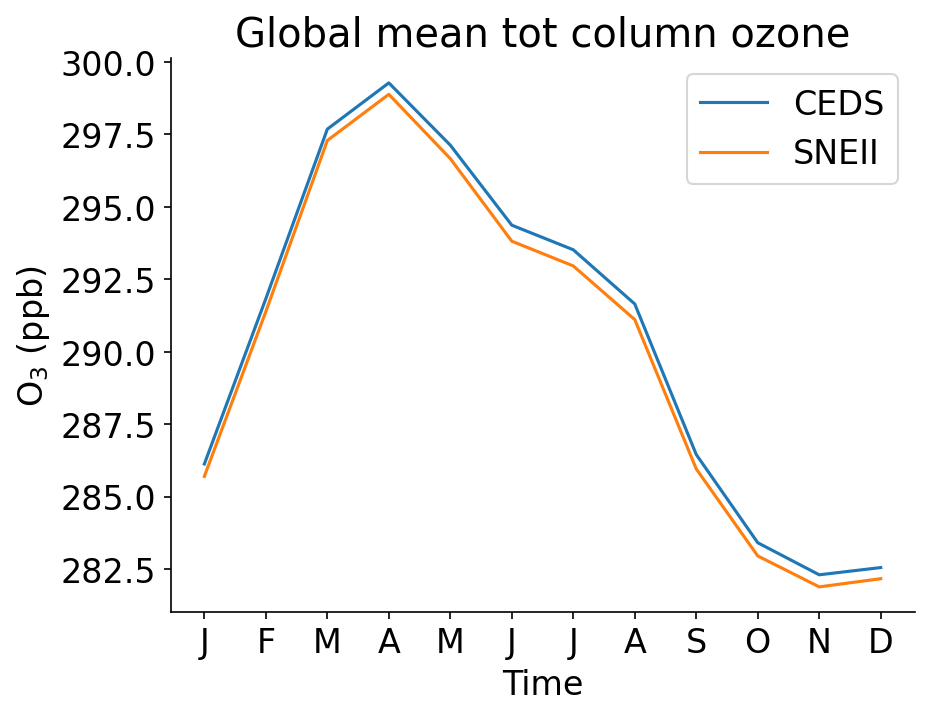

In [19]:
fig = plt.figure(dpi=150)
ax = plt.axes()

# filter df for ticker and plot on specified axes
#calcs['EMAC'].O3_RF_latlontime_mean.plot(y='lev', yincrease=False, label = 'EMAC')
calcs['CEDS'].O3_tot_col_mean.plot(label = 'CEDS')
#calcs['LMDZ-INCA'].O3_RF_latlontime_mean.plot(y='lev', yincrease=False, label = 'LMDZ-INCA')
calcs['SNEII'].O3_tot_col_mean.plot( label = 'SNEII')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# chart formatting
#ax.set_xlim(0,130)
ax.set_xticks(calcs['CEDS'].O3_trop_col_mean.time.data,month_labs)
plt.title(f'Global mean tot column ozone')
ax.set_xlabel('Time')
ax.set_ylabel(f"O$_3$ (ppb)")
plt.legend()

In [20]:
city_names = ['Mumbai','Delhi','Kolkata','Chennai','Bengalūru','Hyderabad']
city_lat_lons = np.array([[72.836447, 18.987807],[77.231495, 28.651952], [88.363044, 22.562627],[80.248357, 13.084622],[77.587106, 12.977063],[78.456355, 17.384052]])

In [21]:
cmap_ol_pu_bk = LinearSegmentedColormap.from_list('Random gradient 442', (
    # Edit this gradient at https://eltos.github.io/gradient/#Random%20gradient%20442=0:FFFFFF-25:B6B610-60:7A7AF3-100:000000
    (0.000, (1.000, 1.000, 1.000)),
    (0.250, (0.714, 0.714, 0.063)),
    (0.600, (0.478, 0.478, 0.953)),
    (1.000, (0.000, 0.000, 0.000))))

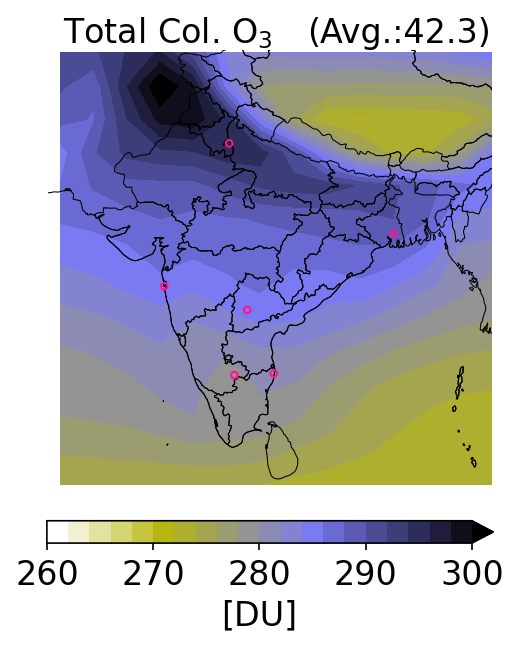

In [22]:
fig, ax = plt.subplots(1, 1, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()))
fg = calcs['SNEII'].O3_tot_column.mean(dim='time').sel(lon=slice(65, 96), lat=slice(5, 35)).plot.contourf(cmap=cmap_ol_pu_bk,
    vmax=300, vmin=260,
    levels=21, 
    #cbar_kwargs={'label': f'[ppb]','location':'bottom','pad': 0.05,'shrink':0.6,'ticks':np.arange(-8,9,2)},
    xlim=(65,95),
    ylim=(5,35),add_colorbar=False
    )

cbar = fig.colorbar(fg,label= f'[DU]',location='bottom',pad= 0.05,shrink=0.6,ticks=np.arange(260,301,10))
cbar.ax.xaxis.set_minor_locator(plt.NullLocator())
#colobar().ax.tick_params(axis='y', direction='in')
#ax.colorbar(location='bottom')
ax.coastlines(linewidth=0.5)  # cartopy function
ax.add_feature(cfeature.STATES,linewidth=0.5)
#ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k',linewidth=0.5,facecolor='w')
plt.text(66,35.5,f'Total Col. O$_3$')
plt.text(82.5,35.5,f'(Avg.:42.3)')
ax.scatter(city_lat_lons[:,0],city_lat_lons[:,1],marker='o',facecolors='none',edgecolors='deeppink',zorder=10,s=10)
ax.axis("off") #remove frame around figure
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
#plt.title(f"SNEII - CEDS")
#plt.savefig(f'{outfile}SNEII_o3_trop_col_map_land_masked.pdf',format='pdf',bbox_inches='tight')

(65.0, 95.0, 5.0, 35.0)

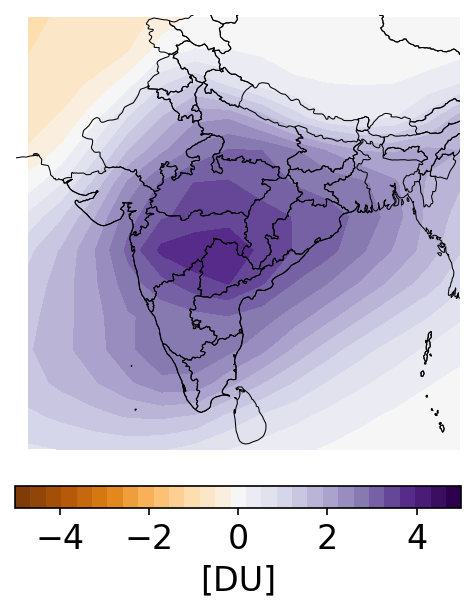

In [23]:
fig, ax = plt.subplots(1, 1, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()))
fg = calcs['diff'].O3_tot_column.mean(dim='time').sel(lon=slice(65, 96), lat=slice(5, 35)).plot.contourf(cmap="PuOr",
    vmax=5, vmin=-5,levels=30, 
    #cbar_kwargs={'label': f'[ppb]','location':'bottom','pad': 0.05,'shrink':0.6,'ticks':np.arange(-8,9,2)},
    xlim=(65,95),
    ylim=(5,35),add_colorbar=False
    )

cbar = fig.colorbar(fg,label= f'[DU]',location='bottom',pad= 0.05,shrink=0.6,ticks=np.arange(-4,5,2))
cbar.ax.xaxis.set_minor_locator(plt.NullLocator())
#colobar().ax.tick_params(axis='y', direction='in')
#ax.colorbar(location='bottom')
ax.coastlines(linewidth=0.5)  # cartopy function
ax.add_feature(cfeature.STATES,linewidth=0.5)
#ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k',linewidth=0.5,facecolor='w')

ax.axis("off") #remove frame around figure
#plt.savefig(f'{outfile}SNEII_CEDS_diff_o3_trop_col_map_land_masked.pdf',format='pdf',bbox_inches='tight')
#plt.title(f"SNEII - CEDS")

(65.0, 95.0, 5.0, 35.0)

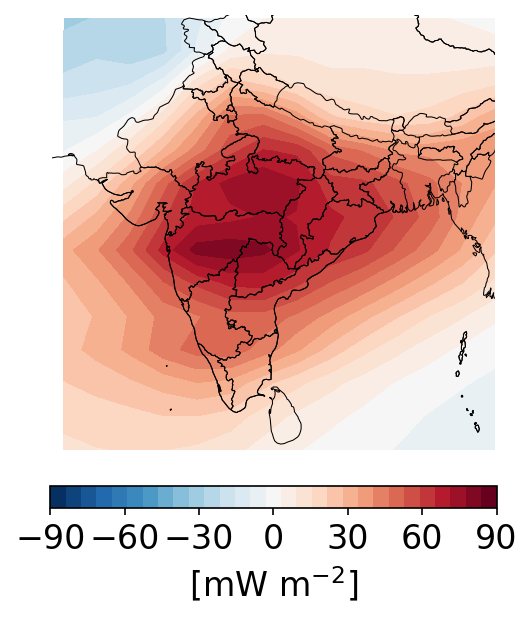

In [24]:
fig, ax = plt.subplots(1, 1, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()))
fg = (calcs['diff'].O3_RF_vert_sum.mean(dim='time').sel(lon=slice(65, 96), lat=slice(5, 35))).plot.contourf(cmap="RdBu_r",
    vmax=90, vmin=-90,levels=30, 
    #cbar_kwargs={'label': f'[ppb]','location':'bottom','pad': 0.05,'shrink':0.6,'ticks':np.arange(-8,9,2)},
    xlim=(65,95),
    ylim=(5,35),add_colorbar=False
    )

cbar = fig.colorbar(fg,label= f'[mW m$^{{-2}}$]',location='bottom',pad= 0.05,shrink=0.6,ticks=np.arange(-90,91,30))
cbar.ax.xaxis.set_minor_locator(plt.NullLocator())
#colobar().ax.tick_params(axis='y', direction='in')
#ax.colorbar(location='bottom')
ax.coastlines(linewidth=0.5)  # cartopy function
ax.add_feature(cfeature.STATES,linewidth=0.5)
#ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k',linewidth=0.5,facecolor='w')

ax.axis("off") #remove frame around figure
#plt.savefig(f'{outfile}SNEII_CEDS_diff_o3_trop_col_map_non_masked.pdf',format='pdf',bbox_inches='tight')

## Multi-panel plots

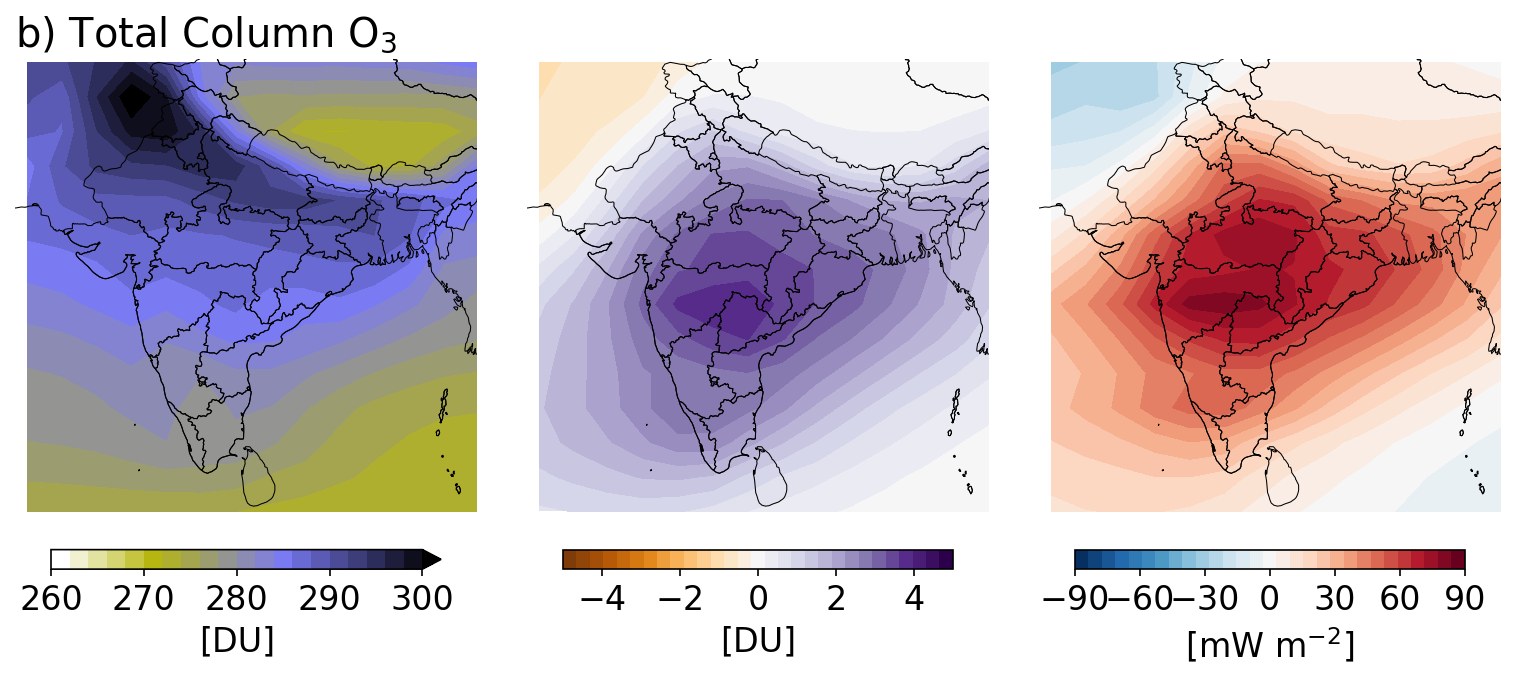

In [32]:
fig, axs = plt.subplots(1, 3, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(13, 5))


# Total column ozone
ax = axs[0]
fg = calcs['SNEII'].O3_tot_column.mean(dim='time').sel(lon=slice(65, 96), lat=slice(5, 35)).plot.contourf(ax=ax, cmap=cmap_ol_pu_bk,
    vmax=300, vmin=260,
    levels=21, 
    #cbar_kwargs={'label': f'[ppb]','location':'bottom','pad': 0.05,'shrink':0.6,'ticks':np.arange(-8,9,2)},
    xlim=(65,95),
    ylim=(5,35),add_colorbar=False
    )

cbar = fig.colorbar(fg,label= f'[DU]',location='bottom',pad= 0.05,shrink=0.8,ticks=np.arange(260,301,10))
cbar.ax.xaxis.set_minor_locator(plt.NullLocator())
#colobar().ax.tick_params(axis='y', direction='in')
#ax.colorbar(location='bottom')
ax.coastlines(linewidth=0.5)  # cartopy function
ax.add_feature(cfeature.STATES,linewidth=0.5)
#ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k',linewidth=0.5,facecolor='w')
ax.set_title('')
ax.set_title(f"b) Total Column O$_3$", loc='left')
#ax.scatter(city_lat_lons[:,0],city_lat_lons[:,1],marker='o',facecolors='none',edgecolors='deeppink',zorder=10,s=10)
ax.axis("off") #remove frame around figure
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())


# Plot 2: Difference map tot column
ax = axs[1]
fg = calcs['diff'].O3_tot_column.mean(dim='time').sel(lon=slice(65, 96), lat=slice(5, 35)).plot.contourf(ax=ax, cmap="PuOr",
    vmax=5, vmin=-5,levels=30, 
    #cbar_kwargs={'label': f'[ppb]','location':'bottom','pad': 0.05,'shrink':0.6,'ticks':np.arange(-8,9,2)},
    xlim=(65,95),
    ylim=(5,35),add_colorbar=False
    )

cbar = fig.colorbar(fg,label= f'[DU]',location='bottom',pad= 0.05,shrink=0.8,ticks=np.arange(-4,5,2))
cbar.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.coastlines(linewidth=0.5)  # cartopy function
ax.add_feature(cfeature.STATES,linewidth=0.5)
#ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k',linewidth=0.5,facecolor='w')
ax.axis("off")

ax = axs[2]
fg = (calcs['diff'].O3_RF_vert_sum.mean(dim='time').sel(lon=slice(65, 96), lat=slice(5, 35))).plot.contourf(ax=ax, cmap="RdBu_r",
    vmax=90, vmin=-90,levels=30, 
    #cbar_kwargs={'label': f'[ppb]','location':'bottom','pad': 0.05,'shrink':0.6,'ticks':np.arange(-8,9,2)},
    xlim=(65,95),
    ylim=(5,35),add_colorbar=False
    )

cbar = fig.colorbar(fg,label= f'[mW m$^{{-2}}$]',location='bottom',pad= 0.05,shrink=0.8,ticks=np.arange(-90,91,30))
cbar.ax.xaxis.set_minor_locator(plt.NullLocator())
#colobar().ax.tick_params(axis='y', direction='in')
#ax.colorbar(location='bottom')
ax.coastlines(linewidth=0.5)  # cartopy function
ax.add_feature(cfeature.STATES,linewidth=0.5)
#ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k',linewidth=0.5,facecolor='w')

ax.axis("off") #remove frame around figure


#plt.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig(f'{outfile}Fig4_tot_col_o3.pdf',format='pdf',bbox_inches='tight')

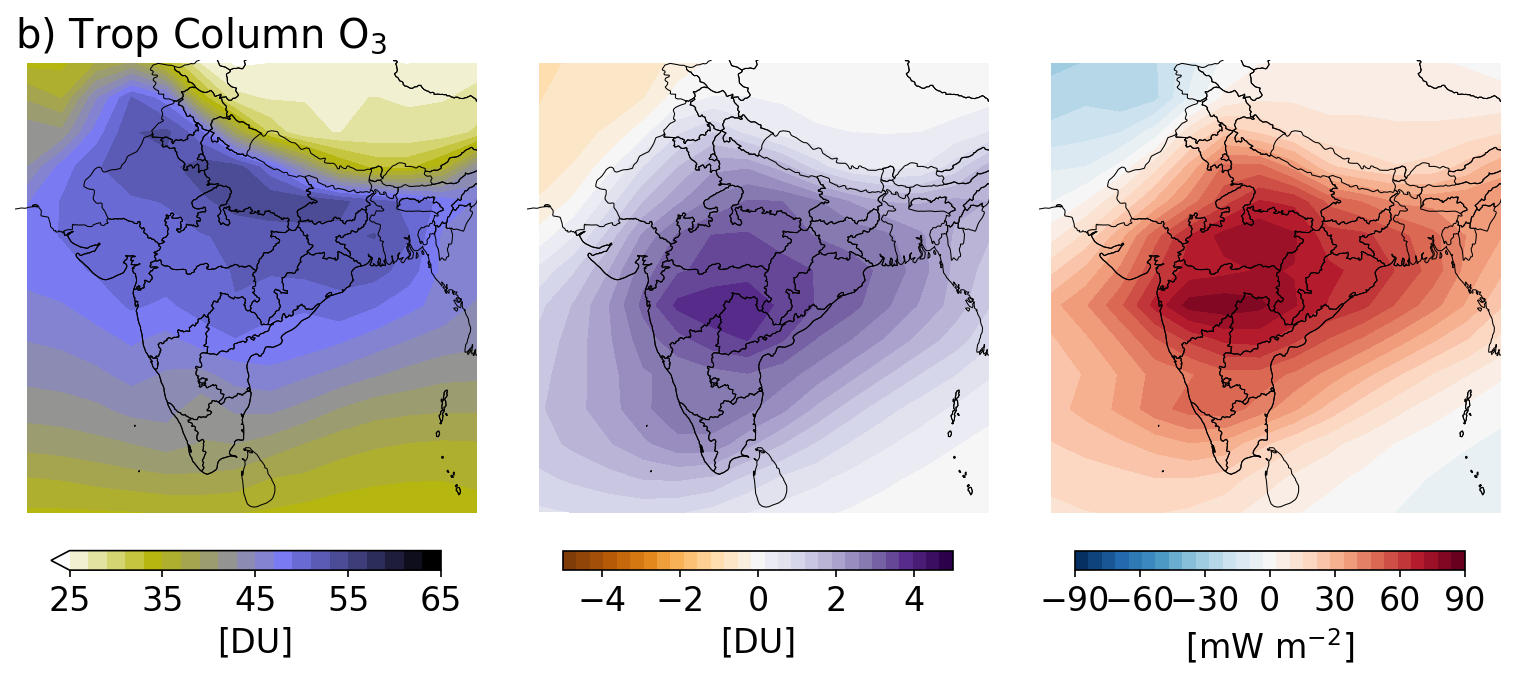

In [33]:
fig, axs = plt.subplots(1, 3, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(13, 5))


# Total column ozone
ax = axs[0]
fg = calcs['SNEII'].O3_trop_column.mean(dim='time').sel(lon=slice(65, 96), lat=slice(5, 35)).plot.contourf(ax=ax, cmap=cmap_ol_pu_bk,
    vmax=65, vmin=25,
    levels=21, 
    #cbar_kwargs={'label': f'[ppb]','location':'bottom','pad': 0.05,'shrink':0.6,'ticks':np.arange(-8,9,2)},
    xlim=(65,95),
    ylim=(5,35),add_colorbar=False
    )

cbar = fig.colorbar(fg,label= f'[DU]',location='bottom',pad= 0.05,shrink=0.8,ticks=np.arange(25,66,10))
cbar.ax.xaxis.set_minor_locator(plt.NullLocator())
#colobar().ax.tick_params(axis='y', direction='in')
#ax.colorbar(location='bottom')
ax.coastlines(linewidth=0.5)  # cartopy function
ax.add_feature(cfeature.STATES,linewidth=0.5)
#ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k',linewidth=0.5,facecolor='w')
ax.set_title('')
ax.set_title(f"b) Trop Column O$_3$", loc='left')
#ax.scatter(city_lat_lons[:,0],city_lat_lons[:,1],marker='o',facecolors='none',edgecolors='deeppink',zorder=10,s=10)
ax.axis("off") #remove frame around figure
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())


# Plot 2: Difference map tot column
ax = axs[1]
fg = calcs['diff'].O3_trop_column.mean(dim='time').sel(lon=slice(65, 96), lat=slice(5, 35)).plot.contourf(ax=ax, cmap="PuOr",
    vmax=5, vmin=-5,levels=30, 
    #cbar_kwargs={'label': f'[ppb]','location':'bottom','pad': 0.05,'shrink':0.6,'ticks':np.arange(-8,9,2)},
    xlim=(65,95),
    ylim=(5,35),add_colorbar=False
    )

cbar = fig.colorbar(fg,label= f'[DU]',location='bottom',pad= 0.05,shrink=0.8,ticks=np.arange(-4,5,2))
cbar.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.coastlines(linewidth=0.5)  # cartopy function
ax.add_feature(cfeature.STATES,linewidth=0.5)
#ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k',linewidth=0.5,facecolor='w')
ax.axis("off")

ax = axs[2]
fg = (calcs['diff'].O3_RF_vert_sum.mean(dim='time').sel(lon=slice(65, 96), lat=slice(5, 35))).plot.contourf(ax=ax, cmap="RdBu_r",
    vmax=90, vmin=-90,levels=30, 
    #cbar_kwargs={'label': f'[ppb]','location':'bottom','pad': 0.05,'shrink':0.6,'ticks':np.arange(-8,9,2)},
    xlim=(65,95),
    ylim=(5,35),add_colorbar=False
    )

cbar = fig.colorbar(fg,label= f'[mW m$^{{-2}}$]',location='bottom',pad= 0.05,shrink=0.8,ticks=np.arange(-90,91,30))
cbar.ax.xaxis.set_minor_locator(plt.NullLocator())
#colobar().ax.tick_params(axis='y', direction='in')
#ax.colorbar(location='bottom')
ax.coastlines(linewidth=0.5)  # cartopy function
ax.add_feature(cfeature.STATES,linewidth=0.5)
#ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k',linewidth=0.5,facecolor='w')

ax.axis("off") #remove frame around figure

#plt.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig(f'{outfile}Fig4_trop_col_o3.pdf',format='pdf',bbox_inches='tight')